# Deep Learning - Module 5 Assignment<br>GAN to create Monet style painting Mini-Project
by M. Giordano

## Introduction

<b>This is a Deep Learning task focused on Generative Models for image synthesis.</b><br>
The task is based on a dataset of digitized paintings by Claude Monet, provided as part of a Kaggle competition dedicated to generative adversarial networks (GAN). <br>
The dataset consists of unlabeled images representing a single artistic style, and the objective is to learn the underlying data distribution in order to generate new, visually coherent images.

<b>Our goal is to participate in the "I’m Something of a Painter Myself" Kaggle competition</b>, and to train a generative deep learning model capable of producing realistic Monet-like paintings, achieving a reasonable MiFID score within the limited scope and time constraints of this weekly assignment.

This will be achieved through EDA, data cleaning, feature engineering, and model development from scratch.

This work covers all the required points of the rubric, following the steps in the same order of appearance:

1. Brief description of the problem and data

2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

3. Model Architecture

4. Results and Analysis

5. Conclusion

## 1.  Brief description of the problem and data

### 1.1 Problem description
<b>This is a Deep Learning task focused on generative modeling with Generative Adversarial Networks (GAN).</b><br>
This assignment is designed to demonstrate both conceptual understanding and practical application of GANs, as introduced and discussed throughout the course. Rather than focusing on competitive performance, the emphasis is on correctly framing the generative problem, implementing a valid GAN-based pipeline, and interpreting the behavior and outputs of the model.

### 1.2 Goal
The goal of this assignment is to apply the GAN concepts introduced in the course within the context of the "I’m Something of a Painter Myself" Monet Painting Kaggle competition, documenting the full workflow and demonstrating a clear understanding of the modeling and evaluation process. 

The achieved leaderboard position is reported for completeness, while the primary emphasis remains on the soundness and clarity of the adopted approach rather than on the absolute score.

### 1.3 Size, dimension, and data structure

In [45]:
globals().clear(); import gc; gc.collect()
import os
import pandas as pd

# Define dataset root directory
DATASET_DIR = "./data"

# List available folders in the dataset directory
available_dirs = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
print("Available dataset folders:", available_dirs)

# Define expected image folders
monet_jpg_dir = os.path.join(DATASET_DIR, "monet_jpg")
photo_jpg_dir = os.path.join(DATASET_DIR, "photo_jpg")
monet_tfrec_dir = os.path.join(DATASET_DIR, "monet_tfrec")
photo_tfrec_dir = os.path.join(DATASET_DIR, "photo_tfrec")

# Count number of files in each folder (if present)
def count_files(folder_path):
    if os.path.exists(folder_path):
        return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    else:
        return 0

print("\nDataset content overview:")
print("monet_jpg images:", count_files(monet_jpg_dir))
print("photo_jpg images:", count_files(photo_jpg_dir))
print("monet_tfrec files:", count_files(monet_tfrec_dir))
print("photo_tfrec files:", count_files(photo_tfrec_dir))

# Inspect a few sample filenames to verify structure
def list_sample_files(folder_path, n=5):
    if os.path.exists(folder_path):
        return os.listdir(folder_path)[:n]
    else:
        return []

print("\nSample files from monet_jpg:", list_sample_files(monet_jpg_dir))
print("Sample files from photo_jpg:", list_sample_files(photo_jpg_dir))

# Summarize intended data usage
summary_df = pd.DataFrame({
    "folder": ["monet_jpg", "photo_jpg", "monet_tfrec", "photo_tfrec"],
    "num_files": [
        count_files(monet_jpg_dir),
        count_files(photo_jpg_dir),
        count_files(monet_tfrec_dir),
        count_files(photo_tfrec_dir)
    ]
})

print("\nDataset summary:")
print(summary_df)


Available dataset folders: ['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec']

Dataset content overview:
monet_jpg images: 300
photo_jpg images: 7038
monet_tfrec files: 5
photo_tfrec files: 20

Sample files from monet_jpg: ['000c1e3bff.jpg', '011835cfbf.jpg', '0260d15306.jpg', '049e293b93.jpg', '05144e306f.jpg']
Sample files from photo_jpg: ['00068bc07f.jpg', '000910d219.jpg', '000ded5c41.jpg', '00104fd531.jpg', '001158d595.jpg']

Dataset summary:
        folder  num_files
0    monet_jpg        300
1    photo_jpg       7038
2  monet_tfrec          5
3  photo_tfrec         20


The dataset is organized into four main folders: `monet_jpg`, `monet_tfrec`, `photo_jpg`, and `photo_tfrec`. 

The `monet_jpg` directory contains 300 JPEG images of Claude Monet paintings, which represent the target artistic style to be learned by the generative model. In contrast, the `photo_jpg` folder includes 7,038 real-world photographs, providing a substantially larger set of images that can be used as source data for style transfer or generative modeling tasks.

Additionally, the dataset provides TensorFlow Record files (`.tfrec`) for both domains, with 5 files for Monet paintings and 20 files for photographs, offering an alternative data loading format optimized for large-scale training. The clear imbalance between the number of Monet paintings and photographs is an important characteristic of the dataset and has implications for model design and training strategy.


### 1.4 What is GAN
A Generative Adversarial Network (GAN) is a class of deep learning models designed to generate new data samples that resemble a given training dataset. 

A GAN is composed of two neural networks trained simultaneously through an adversarial process: a generator and a discriminator.  
The generator learns to produce synthetic data samples starting from random noise, with the objective of making them indistinguishable from real data. The discriminator, on the other hand, is trained to distinguish between real samples from the dataset and fake samples produced by the generator.  

During training, the generator and discriminator compete with each other: the generator improves its ability to create realistic outputs, while the discriminator becomes better at detecting generated samples. 

This adversarial setup allows GANs to model complex data distributions and has proven particularly effective for image generation tasks.


### 1.5 How GAN is evaluated
Evaluating GANs is challenging because there is no direct ground truth for generated samples. Performance is typically assessed by measuring how closely the distribution of generated data matches that of real data, while also considering output diversity and avoiding memorization. Both qualitative inspection and quantitative metrics are commonly used for this purpose.


### 1.6 Kaggle MiFID metric
The Kaggle competition evaluates generated images using the MiFID (Memorization-informed Fréchet Inception Distance) metric. 

MiFID is an extension of the standard FID score, designed to measure the similarity between the distributions of real and generated images while also penalizing models that rely on memorization of the training data.  

Lower MiFID values indicate better generative performance, reflecting images that are both visually similar to real Monet paintings and sufficiently diverse, rather than near-duplicates of the training samples.


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data



### 2.1 Preliminary Data Exploration
In this section, we perform a preliminary exploration of the available data by directly inspecting sample images from each folder. Since the dataset is image-based and unlabeled, visual inspection plays a key role in understanding image quality, resolution, color distribution, and structural differences between domains. We load and visualize a small number of images from each directory to gain an initial qualitative understanding of the data.


In [46]:
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset directories
DATASET_DIR = "./data"
monet_jpg_dir = os.path.join(DATASET_DIR, "monet_jpg")
photo_jpg_dir = os.path.join(DATASET_DIR, "photo_jpg")

# Helper function to load and display images
def display_sample_images(folder_path, title, n=5):
    image_files = os.listdir(folder_path)[:n]
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Display sample Monet paintings
display_sample_images(monet_jpg_dir, "Sample Monet Paintings")

# Display sample real photographs
display_sample_images(photo_jpg_dir, "Sample Photographs")


In [47]:
import tensorflow as tf

# Define TFRecord directories
monet_tfrec_dir = os.path.join(DATASET_DIR, "monet_tfrec")
photo_tfrec_dir = os.path.join(DATASET_DIR, "photo_tfrec")

# Helper function to inspect a TFRecord file
def inspect_tfrec(tfrec_dir, label):
    tfrec_files = [os.path.join(tfrec_dir, f) for f in os.listdir(tfrec_dir) if f.endswith(".tfrec")]
    if not tfrec_files:
        print(f"No TFRecord files found in {label}")
        return
    
    tfrec_path = tfrec_files[0]
    print(f"\nInspecting TFRecord from {label}:")
    print("File:", os.path.basename(tfrec_path))
    
    raw_dataset = tf.data.TFRecordDataset(tfrec_path)
    raw_record = next(iter(raw_dataset))
    
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    # Print available feature keys
    feature_keys = list(example.features.feature.keys())
    print("Available features:", feature_keys)
    
    # Print basic information for each feature
    for key in feature_keys:
        feature = example.features.feature[key]
        if feature.bytes_list.value:
            print(f"{key}: bytes feature (length={len(feature.bytes_list.value[0])})")
        elif feature.int64_list.value:
            print(f"{key}: int64 feature (values={feature.int64_list.value[:5]})")
        elif feature.float_list.value:
            print(f"{key}: float feature (values={feature.float_list.value[:5]})")

# Inspect one TFRecord file per folder
inspect_tfrec(monet_tfrec_dir, "monet_tfrec")
inspect_tfrec(photo_tfrec_dir, "photo_tfrec")


c:\Python\progetti\MASTER\ML1\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):



Inspecting TFRecord from monet_tfrec:
File: monet00-60.tfrec
Available features: ['target', 'image', 'image_name']
target: bytes feature (length=5)
image: bytes feature (length=36297)
image_name: bytes feature (length=10)

Inspecting TFRecord from photo_tfrec:
File: photo00-352.tfrec
Available features: ['target', 'image', 'image_name']
target: bytes feature (length=5)
image: bytes feature (length=20148)
image_name: bytes feature (length=10)


#### 2.1.2 Preliminary Data Exploration Results
The visual inspection of sample images highlights a clear stylistic and structural difference between the two domains.

Monet paintings exhibit soft edges, visible brush strokes, and pastel-dominated color palettes, with less emphasis on sharp contours and fine-grained details. 

In contrast, photographs display high-frequency details, sharper boundaries, and a wider dynamic range in lighting and textures, reflecting their real-world nature. 

These differences confirm the suitability of the dataset for a generative task aimed at learning and reproducing an artistic style.

The inspection of the TFRecord files reveals a consistent and well-defined data structure across both domains.<br>
Each record contains three high-level features: the encoded image data, an image identifier, and a target field used internally by the competition pipeline. The image feature is stored as a byte sequence, with Monet paintings generally having larger encoded sizes than photographs, likely due to differences in texture complexity and compression characteristics.  

Overall, the dataset organization and feature structure are coherent and descriptive, providing all the necessary information for training and evaluating a GAN-based generative model without relying on additional annotations or labels.


### 2.2 Plan of analysis

Based on the initial inspection of the dataset, the analysis is intentionally kept minimal and focused, in line with the scope of an intra-week assignment.

* **Consistency check:** verify that all image files are readable, valid, and share consistent dimensions and color channels, ensuring they can be safely used as input for the generative model.

* **Data visualization:** visually inspect and compare key low-level image characteristics, such as intensity, color distribution, and saturation, in order to highlight systematic differences between Monet paintings and real-world photographs.

* **Data cleaning:** since the dataset is composed of images rather than tabular data, canonical data cleaning procedures (e.g., handling missing values or outliers) are not directly applicable. Instead, the analysis will focus on evaluating whether any image-level cleaning or filtering steps are required, such as removing corrupted files or enforcing uniform formatting, and whether additional cleaning is necessary beyond standard preprocessing.

* **Feature analysis and engineering:** analyze whether and how additional or transformed features may be introduced to support the generative modeling process, assessing their potential usefulness in guiding preprocessing or training strategies.

These steps are sufficient to confirm data usability and to inform subsequent modeling choices without introducing unnecessary complexity beyond the requirements of the assignment.


### 2.3 Data Consistency 

In [48]:
# -------------------------------------------------
# Data consistency check utilities
# -------------------------------------------------

def is_image_valid(img_path):
    """
    Checks whether an image file can be opened and fully loaded.
    This ensures that corrupted or unreadable files are excluded.
    """
    try:
        with Image.open(img_path) as img:
            img.verify()  # verifies image integrity without loading pixel data
        return True
    except Exception:
        return False


def get_image_shape(img_path):
    """
    Returns image dimensions (width, height) and number of channels.
    Used to verify dimensional consistency across the dataset.
    """
    with Image.open(img_path) as img:
        img = img.convert("RGB")  # enforce RGB to standardize channel count
        return img.size[0], img.size[1], len(img.getbands())


def check_folder_consistency(folder_path, max_files=None):
    """
    Iterates through images in a folder to:
    - check validity of each image
    - collect shape information for consistency analysis
    """
    shapes = []
    invalid_files = []

    file_list = os.listdir(folder_path)
    if max_files:
        file_list = file_list[:max_files]  # optional cap to limit runtime

    for fname in file_list:
        img_path = os.path.join(folder_path, fname)
        if not is_image_valid(img_path):
            invalid_files.append(fname)
        else:
            shapes.append(get_image_shape(img_path))
            
    invalid_files = "None" if invalid_files == [] else invalid_files


    return shapes, invalid_files


def summarize_shapes(shapes):
    """
    Summarizes unique image shapes found in the dataset.
    Helps identify whether resizing or normalization is required.
    """
    return set(shapes)


# -------------------------------------------------
# Run consistency checks
# -------------------------------------------------

monet_shapes, monet_invalid = check_folder_consistency(monet_jpg_dir)
photo_shapes, photo_invalid = check_folder_consistency(photo_jpg_dir, max_files=300)


print("Monet dataset consistency check")
print("Unique image shapes:", summarize_shapes(monet_shapes))
print("Invalid files:", monet_invalid)

print("\nPhoto dataset consistency check (sampled)")
print("Unique image shapes:", summarize_shapes(photo_shapes))
print("Invalid files:", photo_invalid)


Monet dataset consistency check
Unique image shapes: {(256, 256, 3)}
Invalid files: None

Photo dataset consistency check (sampled)
Unique image shapes: {(256, 256, 3)}
Invalid files: None


The consistency check confirms that all inspected images are valid and share the same spatial dimensions and number of channels. Since the dataset consists exclusively of image data with no missing values or structural inconsistencies, canonical data cleaning procedures commonly applied to tabular datasets are not applicable in this context.


### 2.4 Data Visualization

In [49]:
import numpy as np
import colorsys
from collections import Counter

# -----------------------------
# Load Monet images (all)
# -----------------------------
monet_images = []
for fname in os.listdir(monet_jpg_dir):
    try:
        img = Image.open(os.path.join(monet_jpg_dir, fname)).convert("RGB")
        monet_images.append(np.array(img))
    except:
        pass

# -----------------------------
# Load Photo images (sample first 300)
# -----------------------------
photo_images = []
for fname in os.listdir(photo_jpg_dir)[:300]:
    try:
        img = Image.open(os.path.join(photo_jpg_dir, fname)).convert("RGB")
        photo_images.append(np.array(img))
    except:
        pass



In [50]:

# -----------------------------
# Helper computations
# -----------------------------
def pixel_intensity(images):
    """Compute grayscale-like pixel intensity for a set of images."""
    return np.concatenate([img.mean(axis=2).flatten() for img in images])

def rgb_channels(images):
    """Extract flattened RGB channel values from a set of images."""
    r = np.concatenate([img[:, :, 0].flatten() for img in images])
    g = np.concatenate([img[:, :, 1].flatten() for img in images])
    b = np.concatenate([img[:, :, 2].flatten() for img in images])
    return r, g, b

def saturation_values(images):
    """Compute pixel-level saturation values in HSV space."""
    def compute_sat(img):
        hsv = np.apply_along_axis(
            lambda x: colorsys.rgb_to_hsv(x[0]/255, x[1]/255, x[2]/255),
            2,
            img
        )
        return hsv[:, :, 1].flatten()
    return np.concatenate([compute_sat(img) for img in images])

def mean_saturation(img):
    """Compute mean saturation for a single image."""
    hsv = np.apply_along_axis(
        lambda x: colorsys.rgb_to_hsv(x[0]/255, x[1]/255, x[2]/255),
        2,
        img
    )
    return hsv[:, :, 1].mean()

def dominant_channel(img):
    """Identify dominant RGB channel based on mean intensity."""
    return np.argmax(img.mean(axis=(0, 1)))  # 0=R, 1=G, 2=B

def saturation_category(val):
    """Discretize saturation into interpretable categories."""
    if val < 0.2:
        return "Low"
    elif val < 0.5:
        return "Medium"
    else:
        return "High"

# -----------------------------
# Compute statistics
# -----------------------------
monet_intensity = pixel_intensity(monet_images)
photo_intensity = pixel_intensity(photo_images)

monet_r, monet_g, monet_b = rgb_channels(monet_images)
photo_r, photo_g, photo_b = rgb_channels(photo_images)

monet_sat = saturation_values(monet_images)
photo_sat = saturation_values(photo_images)

monet_sat_cats = [saturation_category(mean_saturation(img)) for img in monet_images]
photo_sat_cats = [saturation_category(mean_saturation(img)) for img in photo_images]

monet_dom = [dominant_channel(img) for img in monet_images]
photo_dom = [dominant_channel(img) for img in photo_images]

monet_sat_counts = Counter(monet_sat_cats)
photo_sat_counts = Counter(photo_sat_cats)

monet_dom_counts = Counter(monet_dom)
photo_dom_counts = Counter(photo_dom)

# -----------------------------
# Plot: single 3x3 dashboard
# -----------------------------
plt.figure(figsize=(18, 15))

# ---- Row 1: Monet ----
plt.subplot(3, 3, 1)
plt.hist(monet_intensity, bins=50, color="#AEC6CF")
plt.axvline(monet_intensity.mean(), color="#FF6961", linestyle="--")
plt.title("Monet pixel intensity")

plt.subplot(3, 3, 2)
plt.hist(monet_r, bins=50, color="#FF6961", alpha=0.4, label="Red")
plt.hist(monet_g, bins=50, color="#77DD77", alpha=0.4, label="Green")
plt.hist(monet_b, bins=50, color="#779ECB", alpha=0.4, label="Blue")
plt.title("Monet RGB distribution")
plt.legend()

plt.subplot(3, 3, 3)
plt.hist(monet_sat, bins=50, color="#B39EB5")
plt.axvline(monet_sat.mean(), color="#FFB347", linestyle="--")
plt.title("Monet saturation (HSV)")

# ---- Row 2: Photos ----
plt.subplot(3, 3, 4)
plt.hist(photo_intensity, bins=50, color="#CFCFC4")
plt.axvline(photo_intensity.mean(), color="#FF6961", linestyle="--")
plt.title("Photo pixel intensity (sampled)")

plt.subplot(3, 3, 5)
plt.hist(photo_r, bins=50, color="#FF6961", alpha=0.4, label="Red")
plt.hist(photo_g, bins=50, color="#77DD77", alpha=0.4, label="Green")
plt.hist(photo_b, bins=50, color="#779ECB", alpha=0.4, label="Blue")
plt.title("Photo RGB distribution (sampled)")
plt.legend()

plt.subplot(3, 3, 6)
plt.hist(photo_sat, bins=50, color="#CB99C9")
plt.axvline(photo_sat.mean(), color="#FFB347", linestyle="--")
plt.title("Photo saturation (HSV, sampled)")

# ---- Row 3: Pie charts ----
sat_labels = ["Low", "Medium", "High"]
sat_colors = ["#AEC6CF", "#FFB347", "#B39EB5"]

rgb_labels = ["Red-dominant", "Green-dominant", "Blue-dominant"]
rgb_colors = ["#FF6961", "#77DD77", "#779ECB"]

plt.subplot(3, 3, 7)
plt.pie([monet_sat_counts[l] for l in sat_labels],
        labels=sat_labels, autopct="%1.1f%%", colors=sat_colors)
plt.title("Monet saturation categories")

plt.subplot(3, 3, 8)
plt.pie([photo_sat_counts[l] for l in sat_labels],
        labels=sat_labels, autopct="%1.1f%%", colors=sat_colors)
plt.title("Photo saturation categories")

plt.subplot(3, 3, 9)
plt.pie(
    [
        monet_dom_counts[0] + photo_dom_counts[0],
        monet_dom_counts[1] + photo_dom_counts[1],
        monet_dom_counts[2] + photo_dom_counts[2],
    ],
    labels=rgb_labels, autopct="%1.1f%%", colors=rgb_colors
)
plt.title("Dominant color distribution")

plt.tight_layout()
plt.show()

#### 2.4.2 Data visualization analysis

Inspecting the plots, we can derive these conclusions:

* **Pixel intensity:** Monet images are mainly concentrated around mid-range intensity values, showing smoother luminance transitions, while photographs exhibit a broader distribution with higher contrast and more extreme values.

* **RGB channel distribution:** Monet paintings display largely overlapping RGB distributions, indicating balanced and blended color usage, whereas photographs show more uneven channel behavior and sharper variations.

* **Saturation (HSV):** Monet images tend to have more structured and moderately higher saturation levels, while photographs present a wider spread with a larger proportion of low-saturation pixels.

* **Saturation categories:** The majority of Monet paintings fall into the medium saturation category, while photographs are more evenly distributed across low, medium, and high saturation levels.

* **Dominant color:** The dominant color distribution is relatively balanced across RGB channels, suggesting the absence of a strong chromatic bias and the need for the model to learn a diversified color representation.

Considering the internal workflow of a GAN network, we can deduce that the generator must capture not only spatial patterns but also consistent color and saturation distributions to effectively reproduce the artistic style of Monet paintings.


### 2.5 Data Cleaning

In the context of an image-based generative task, traditional data cleaning operations such as handling missing values or correcting invalid entries are not applicable. Given the results of the consistency checks, all images are valid and share the same dimensions and format.

The only meaningful data cleaning step in this scenario is to verify the absence of duplicated images within each dataset. Duplicate samples could bias the training process of a GAN by over-emphasizing specific visual patterns and reducing the effective diversity of the data. Therefore, a duplicate detection step based on image content is performed.


In [6]:
import hashlib
from PIL import Image
import os

# -------------------------------------------------
# Duplicate detection utilities
# -------------------------------------------------

def compute_image_hash(img_path):
    """
    Computes a hash of the raw image bytes.
    This allows detecting exact duplicate images efficiently.
    """
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        return hashlib.md5(img.tobytes()).hexdigest()


def find_duplicates(folder_path, max_files=None):
    """
    Scans a folder and identifies duplicate images based on content hash.
    Returns a dictionary mapping hash -> list of filenames.
    """
    hashes = {}
    duplicates = {}

    file_list = os.listdir(folder_path)
    if max_files:
        file_list = file_list[:max_files]  # optional limit for large folders

    for fname in file_list:
        img_path = os.path.join(folder_path, fname)
        try:
            img_hash = compute_image_hash(img_path)
            if img_hash in hashes:
                duplicates.setdefault(img_hash, [hashes[img_hash]]).append(fname)
            else:
                hashes[img_hash] = fname
        except Exception:
            pass

    return duplicates


# -------------------------------------------------
# Run duplicate checks
# -------------------------------------------------

monet_duplicates = find_duplicates(monet_jpg_dir)
photo_duplicates = find_duplicates(photo_jpg_dir, max_files=300)

print("Duplicate check — Monet images")
print("Duplicates found:", monet_duplicates if monet_duplicates else "None")

print("\nDuplicate check — Photo images (sampled)")
print("Duplicates found:", photo_duplicates if photo_duplicates else "None")


Duplicate check — Monet images
Duplicates found: None

Duplicate check — Photo images (sampled)
Duplicates found: None


### 2.6 Feature Engineering

As a GAN architecture operates directly on raw image data and iteratively refines the generated output through the adversarial interaction between generator and discriminator, its primary inputs consist of pixel-level representations rather than handcrafted features. The learning process is entirely driven by the model’s ability to internally extract and refine hierarchical visual representations from the data.

Therefore, there is no practical benefit in introducing additional derived features, as this would neither simplify the learning process nor align with standard GAN training paradigms. Feature extraction and representation learning are implicitly handled by the network itself during training.

The most relevant form of extra information is instead provided through image-level preprocessing, such as consistent resizing, normalization, and color space standardization, as well as through efficient data handling formats. In this context, the provided TFRecord files can be interpreted as an optimized container for visual features, supporting efficient data loading without altering the semantic content of the images.


### 2.7 EDA Conclusions

The exploratory data analysis highlights a clear and consistent domain gap between Monet paintings and real-world photographs. While both datasets share identical spatial dimensions and valid image formats, their low-level visual characteristics differ substantially in terms of intensity distribution, color balance, and saturation behavior.

Monet paintings exhibit smoother luminance transitions, more balanced RGB channel distributions, and more structured saturation patterns, reflecting the stylistic properties of impressionist artwork.

In contrast, photographic images show higher variability, stronger contrasts, and a wider range of saturation levels, consistent with natural scene imagery.

These observations confirm that the task is not a simple image generation problem, but a style-oriented generative challenge in which the model must learn to bridge a non-trivial domain gap. This insight motivates the use of a GAN-based architecture capable of capturing both spatial structure and distributional color properties, and provides a solid foundation for the modeling choices discussed in the following sections.


## 3. Model Architecture

In this section, we describe the generative models adopted for this assignment. Given the scope of an intra-week project and the characteristics of the dataset, the modeling strategy is intentionally kept simple, interpretable, and aligned with standard practices in generative deep learning.

A **DCGAN (Deep Convolutional Generative Adversarial Network)** is used as a baseline model. DCGAN represents a canonical and well-established architecture for image generation tasks and provides a solid reference point for evaluating generative performance and training behavior.

As a second model, we adopt a **Wasserstein GAN with Gradient Penalty (WGAN-GP)**. This model builds upon the baseline architecture while introducing a different loss formulation designed to improve training stability and mitigate common GAN issues such as mode collapse, which are particularly relevant when working with limited amounts of target-domain data, such as the Monet paintings in this dataset.

The use of these two models allows for a clear and controlled comparison between a standard GAN formulation and a more stable, theoretically grounded variant, while keeping architectural complexity within reasonable bounds for the assignment.

### 3.1 DCGAN

The Deep Convolutional Generative Adversarial Network (DCGAN) extends the original GAN formulation by replacing fully connected layers with convolutional and transposed convolutional layers. This architectural choice makes DCGAN particularly well suited for image generation tasks, as it allows the model to explicitly exploit the spatial structure of visual data.

Compared to a vanilla GAN, DCGAN introduces a more structured generator and discriminator design, typically incorporating convolutional blocks, normalization layers, and nonlinear activations. These elements contribute to more stable training and improved visual quality of the generated images, making DCGAN a standard baseline for image-based generative modeling.

Given the characteristics of the Monet paintings, we expect the DCGAN baseline to learn coarse stylistic elements such as global color distributions, dominant textures, and overall composition patterns. While fine-grained details and high visual fidelity may be limited by the simplicity of the architecture and the relatively small number of Monet samples, the model is expected to capture the overall impressionist style, providing a meaningful reference point for evaluating improvements introduced by more stable GAN variants.


In [ ]:
# =================================================
# Sanity check — inspection of real Monet images
# Confirms that input data are correct before GAN training
# =================================================

import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# -------------------------------------------------
# Reuse the same transform used for GAN training
# ------------------------------------------------
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 128
FEATURES_GEN = 128
FEATURES_DISC = 128

transform_check = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5] * CHANNELS_IMG,
        [0.5] * CHANNELS_IMG
    )
])

# -------------------------------------------------
# Select first 10 images from preloaded list
# -------------------------------------------------
num_samples = 10
sample_images = monet_images[:num_samples]

# -------------------------------------------------
# Plot raw images (no preprocessing)
# -------------------------------------------------
plt.figure(figsize=(15, 3))
for i, img_np in enumerate(sample_images):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(img_np)
    plt.axis("off")
    if i == 0:
        plt.ylabel("Raw", fontsize=10)

# -------------------------------------------------
# Plot preprocessed images (as seen by the GAN)
# -------------------------------------------------
for i, img_np in enumerate(sample_images):
    img_pil = Image.fromarray(img_np)
    img_tensor = transform_check(img_pil)

    # Denormalize for visualization
    img_denorm = (img_tensor + 1) / 2
    img_denorm = img_denorm.permute(1, 2, 0).clamp(0, 1).numpy()

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(img_denorm)
    plt.axis("off")
    if i == 0:
        plt.ylabel("Preprocessed", fontsize=10)

plt.suptitle("Sanity Check: Real Monet Images (Raw vs Preprocessed)", fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
# =================================================
# DCGAN baseline — self-contained training cell
# Uses images already loaded in `monet_images`
# =================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

# -------------------------------------------------
# Device configuration
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------
# Hyperparameters (baseline, conservative)
# -------------------------------------------------
IMAGE_SIZE = 256
CHANNELS_IMG = 3
Z_DIM = 128
FEATURES_GEN = 128
FEATURES_DISC = 128
BATCH_SIZE = 16
LR = 2e-4
BETAS = (0.5, 0.999)
NUM_EPOCHS = 15

# -------------------------------------------------
# Dataset wrapper for preloaded images
# -------------------------------------------------
class MonetDataset(Dataset):
    """
    Dataset wrapper for Monet images already loaded in memory
    as numpy arrays of shape (H, W, 3).
    """
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray(img)  # convert numpy array to PIL
        if self.transform:
            img = self.transform(img)
        return img

# -------------------------------------------------
# Image preprocessing
# -------------------------------------------------
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5] * CHANNELS_IMG,
        [0.5] * CHANNELS_IMG
    )
])

dataset = MonetDataset(
    images=monet_images,   # <-- preloaded list from previous cell
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

# -------------------------------------------------
# Generator
# -------------------------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            self._block(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------------------------------
# Discriminator
# -------------------------------------------------
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.net(x).view(-1)




In [ ]:
# -------------------------------------------------
# Model initialization
# -------------------------------------------------
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# -------------------------------------------------
# Loss and optimizers
# -------------------------------------------------
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=BETAS)
opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=BETAS)

# -------------------------------------------------
# Training loop
# -------------------------------------------------
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for real in dataloader:
        real = real.to(device)
        batch_size = real.size(0)

        # ---------------------
        # Train Discriminator
        # ---------------------
        noise = torch.randn(batch_size, Z_DIM, 1, 1, device=device)
        fake = gen(noise)

        disc_real = disc(real)
        disc_fake = disc(fake.detach())

        loss_disc = (
            criterion(disc_real, torch.ones_like(disc_real)) +
            criterion(disc_fake, torch.zeros_like(disc_fake))
        ) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # ---------------------
        # Train Generator
        # ---------------------
        output = disc(fake)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
        f"Loss D: {loss_disc.item():.4f} | Loss G: {loss_gen.item():.4f}"
    )

In [ ]:
# =================================================
# DCGAN — qualitative inspection of generated images
# Generates and visualizes at least 10 samples
# =================================================

import torch
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------
# Switch generator to eval mode
# -------------------------------------------------
gen.eval()

# -------------------------------------------------
# Generate samples from noise
# -------------------------------------------------
NUM_SAMPLES = 16  # generate more than 10 for a clean grid
noise = torch.randn(NUM_SAMPLES, Z_DIM, 1, 1, device=device)

with torch.no_grad():
    fake_images = gen(noise).cpu()

# -------------------------------------------------
# Denormalize from [-1, 1] to [0, 1]
# -------------------------------------------------
fake_images = (fake_images + 1) / 2
fake_images = fake_images.clamp(0, 1)

# -------------------------------------------------
# Visualization
# -------------------------------------------------
grid_size = int(np.sqrt(NUM_SAMPLES))
plt.figure(figsize=(8, 8))

for i in range(NUM_SAMPLES):
    plt.subplot(grid_size, grid_size, i + 1)
    img = fake_images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("DCGAN — Generated Monet-style Samples", fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Restore training mode if needed later
# -------------------------------------------------
#gen.train()


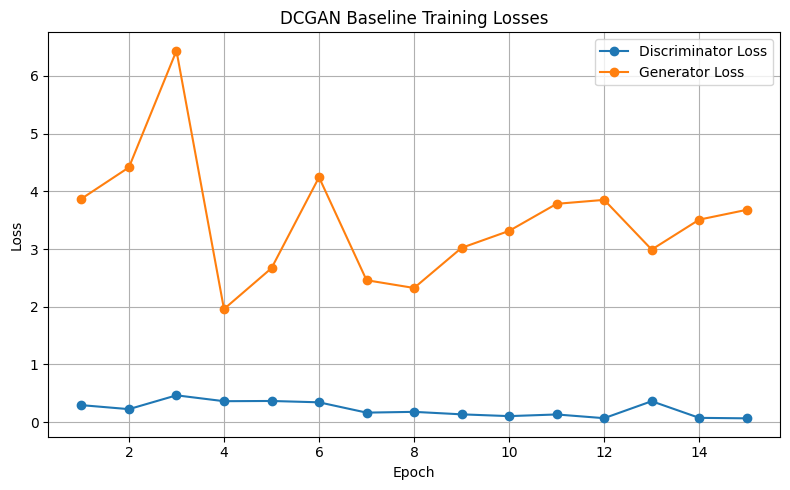

In [ ]:
import matplotlib.pyplot as plt

# Loss values collected during training
loss_d = [
    0.2959, 0.2265, 0.4660, 0.3643, 0.3681,
    0.3449, 0.1663, 0.1797, 0.1366, 0.1058,
    0.1345, 0.0701, 0.3640, 0.0758, 0.0673
]

loss_g = [
    3.8707, 4.4146, 6.4349, 1.9599, 2.6684,
    4.2429, 2.4599, 2.3254, 3.0204, 3.3140,
    3.7830, 3.8513, 2.9904, 3.5091, 3.6789
]

epochs = range(1, len(loss_d) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_d, label="Discriminator Loss", marker="o")
plt.plot(epochs, loss_g, label="Generator Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DCGAN Baseline Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3.1.2 DCGAN (baseline) Results
With this standard combination of parameters adopted as a baseline, the loss curves exhibit a behavior that is consistent with the observed visual output: the discriminator quickly gains dominance, while the generator struggles to stabilize and produce structurally meaningful samples. The oscillations and magnitude of the losses indicate an unstable training process, with no sustained equilibrium between the two networks.

The generated samples clearly reflect this condition. Although the color distribution is loosely aligned with Monet’s style, the images remain heavily blurred, repetitive, and lack any recognizable semantic structure. As a result, this DCGAN implementation, in its baseline configuration, proves unsuitable for the objectives of the competition. For this reason, a second model will be explored in the next section to address the limitations observed here.


### 3.2 Wasserstein GAN with Gradient Penalty (WGAN-GP) 

The second model adopted in this work is **WGAN-GP (Wasserstein GAN with Gradient Penalty)**, selected to address the instability and collapse issues observed with the DCGAN baseline.

Unlike vanilla GANs and DCGANs, which rely on a binary cross-entropy objective derived from a classification task, WGAN-GP reformulates adversarial training as the minimization of the Wasserstein distance between real and generated data distributions. This change provides smoother and more informative gradients, even when the critic becomes strong, and leads to a loss signal that better reflects the quality of generated samples.

In addition to the different loss formulation, WGAN-GP replaces the discriminator with a *critic* that produces unconstrained real-valued outputs and removes the final sigmoid activation. The Lipschitz constraint required by the Wasserstein framework is enforced through a gradient penalty term, which improves numerical stability compared to earlier approaches such as weight clipping. 

Training is further adjusted by updating the critic multiple times for each generator update. Together, these architectural and procedural differences make WGAN-GP more suitable for learning complex artistic distributions from limited data, motivating its use as the second model in this study.


In [ ]:
# =================================================
# WGAN-GP implementation (PyTorch, self-contained)
# Uses monet_images already loaded in memory
# =================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# -------------------------------------------------
# Device
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------
# Hyperparameters (WGAN-GP baseline)
# -------------------------------------------------
IMAGE_SIZE = 256
CHANNELS_IMG = 3
Z_DIM = 128
FEATURES_GEN = 128
FEATURES_CRITIC = 128
BATCH_SIZE = 8
LR = 1e-4
BETAS = (0.0, 0.9)        # WGAN-GP recommended
NUM_EPOCHS = 20
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# -------------------------------------------------
# Dataset wrapper (from in-memory images)
# -------------------------------------------------
class MonetDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = torch.tensor(img, dtype=torch.float32)
        img = img.permute(2, 0, 1)          # HWC → CHW
        img = (img / 127.5) - 1.0            # Normalize to [-1, 1]
        return img

dataset = MonetDataset(monet_images)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# -------------------------------------------------
# Generator
# -------------------------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 32, 4, 1, 0),   # 1 → 4
            self._block(features_g * 32, features_g * 16, 4, 2, 1),  # 4 → 8
            self._block(features_g * 16, features_g * 8, 4, 2, 1),   # 8 → 16
            self._block(features_g * 8, features_g * 4, 4, 2, 1),    # 16 → 32
            self._block(features_g * 4, features_g * 2, 4, 2, 1),    # 32 → 64
            self._block(features_g * 2, features_g, 4, 2, 1),        # 64 → 128
            nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1),  # 128 → 256
            nn.Tanh()
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)


# -------------------------------------------------
# Critic (no sigmoid)
# -------------------------------------------------
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0)
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p, bias=False),
            nn.InstanceNorm2d(out_c, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.net(x).view(-1)

# -------------------------------------------------
# Gradient penalty
# -------------------------------------------------
def gradient_penalty(critic, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated)

    grad = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    grad = grad.view(grad.size(0), -1)
    gp = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# -------------------------------------------------
# Model init
# -------------------------------------------------
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=BETAS)
opt_critic = optim.Adam(critic.parameters(), lr=LR, betas=BETAS)

# -------------------------------------------------
# Training loop
# -------------------------------------------------
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import copy

# -------------------------------------------------
# Fixed noise for visual comparison across epochs
# -------------------------------------------------
FIXED_NOISE = torch.randn(5, Z_DIM, 1, 1, device=device)

# -------------------------------------------------
# Tracking best model (simple stability-based proxy)
# -------------------------------------------------
best_gen_state = None
best_epoch = -1
best_score = float("inf")  # lower is better (heuristic)

# -------------------------------------------------
# Training loop with snapshots
# -------------------------------------------------
gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss_c = []
    epoch_loss_g = []

    for real in dataloader:
        real = real.to(device)

        # ---------------------
        # Train Critic
        # ---------------------
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(real.size(0), Z_DIM, 1, 1, device=device)
            fake = gen(noise)

            critic_real = critic(real)
            critic_fake = critic(fake.detach())

            gp = gradient_penalty(critic, real, fake.detach())
            loss_critic = (
                -(critic_real.mean() - critic_fake.mean())
                + LAMBDA_GP * gp
            )

            critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

        # ---------------------
        # Train Generator
        # ---------------------
        noise = torch.randn(real.size(0), Z_DIM, 1, 1, device=device)
        fake = gen(noise)
        loss_gen = -critic(fake).mean()

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        epoch_loss_c.append(loss_critic.item())
        epoch_loss_g.append(loss_gen.item())

    # -------------------------------------------------
    # Epoch summary
    # -------------------------------------------------
    mean_c = sum(epoch_loss_c) / len(epoch_loss_c)
    mean_g = sum(epoch_loss_g) / len(epoch_loss_g)

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
        f"Loss Critic: {mean_c:.4f} | Loss Gen: {mean_g:.4f}"
    )

    # -------------------------------------------------
    # Snapshot every 2 epochs
    # ------------------------------------------------- 
    if (epoch + 1) % 2 == 0:
        gen.eval()
        with torch.no_grad():
            fake_imgs = gen(FIXED_NOISE).cpu()
            fake_imgs = (fake_imgs + 1) / 2  # back to [0,1]

        plt.figure(figsize=(10, 2))
        plt.title(f"Generated samples at epoch {epoch+1}")
        plt.axis("off")
        plt.imshow(
            vutils.make_grid(fake_imgs, nrow=5, padding=2).permute(1, 2, 0)
        )
        plt.show()
        gen.train()

    # -------------------------------------------------
    # Best checkpoint (heuristic, not metric-based)
    # -------------------------------------------------
    stability_score = abs(mean_c) + abs(mean_g)

    if stability_score < best_score:
        best_score = stability_score
        best_epoch = epoch + 1
        best_gen_state = copy.deepcopy(gen.state_dict())

# -------------------------------------------------
# Restore best generator
# -------------------------------------------------
if best_gen_state is not None:
    gen.load_state_dict(best_gen_state)
    print(f"Best generator restored from epoch {best_epoch}")


#### 3.2.2 DCGAN and WGAN-GP Results – Limitations of Unconditional GANs

Both DCGAN and WGAN-GP were implemented correctly and trained following standard best practices for unconditional generative models. From a numerical perspective, the training processes remain stable, and the loss values evolve within expected ranges for their respective formulations. In particular, WGAN-GP improves training stability compared to DCGAN, reducing abrupt oscillations and preventing early collapse.

However, a consistent limitation emerges from the visual analysis of the generated samples. In both models, the generators converge toward exploiting low-level statistics of the Monet dataset, such as average color distributions and simple texture patterns, while failing to capture higher-level semantic structures. The outputs remain blurry, repetitive, and strongly biased toward a narrow set of colors, with minimal diversity across samples. Increasing resolution, tuning hyperparameters, or extending training does not fundamentally change this behavior.

These results highlight a structural limitation of unconditional GANs in this context. With only ~300 Monet paintings available as the sole source of supervision, the models lack sufficient constraints to learn a meaningful mapping toward complex Monet-style scenes. Instead, they converge to visually weak local optima that satisfy the discriminator without producing semantically coherent images.

For this reason, despite their correct implementation and stable training behavior, both DCGAN and WGAN-GP prove inadequate for the objectives of the competition. Following the tutorial explicitly recommended in the competition description, the next section adopts a CycleGAN architecture, which introduces a cross-domain learning signal by leveraging the large photo dataset and enforcing cycle consistency to guide the generation process toward structurally meaningful Monet-style images.

### 3.3 CycleGAN

The third model adopted in this work is a CycleGAN architecture. Unlike DCGAN and WGAN-GP, which are unconditional generative models trained solely on Monet paintings, CycleGAN is specifically designed for **unpaired image-to-image translation** between two visual domains. In this competition setting, the two domains are Monet paintings and real-world photographs, which are available in large quantity but without explicit pairwise correspondence.

CycleGAN introduces two generators and two discriminators, learning simultaneous mappings from photos to Monet-style images and from Monet paintings back to photos. The key element that differentiates CycleGAN from standard GANs is the **cycle-consistency constraint**: an image translated from one domain to the other and back again should closely resemble the original input. This constraint provides a strong structural regularization signal, preventing the generators from collapsing to trivial texture patterns or average color statistics, as observed in unconditional GANs.

Given the limited size of the Monet dataset (~300 images) and the much larger photo dataset (~7,000 images), this architecture is particularly well suited to the competition. By leveraging the photo domain as a structural reference and enforcing consistency across translations, CycleGAN can learn stylistic transformations while preserving scene layout, object boundaries, and global composition. For these reasons, we expect CycleGAN to produce visually coherent Monet-style images that are significantly more aligned with the objectives and evaluation criteria of the competition.


In [64]:
# CycleGAN single-cell, fully self-contained (dataset loading + training + checkpointing)

import os
import random
import gc
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.utils import save_image

# -----------------------
# Paths (ONLY THINGS TO ADAPT IF NEEDED)
# -----------------------
MONET_DIR = "data/monet_jpg"
PHOTO_DIR = "data/photo_jpg"
CHECKPOINT_PATH = "cyclegan_ckpt.pt"
FAKE_DIR = "fake_monet"
os.makedirs(FAKE_DIR, exist_ok=True)

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Controls
# -----------------------
EPOCHS = 15
MAX_STEPS_PER_EPOCH = 15
BATCH_SIZE = 1

IMAGE_SIZE = 256
CHANNELS_IMG = 3
LAMBDA = 10.0


# -----------------------
# Transforms
# -----------------------
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*CHANNELS_IMG, [0.5]*CHANNELS_IMG),
])

# -----------------------
# Utility: load image paths
# -----------------------
def load_image_paths(folder):
    return [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

monet_images = load_image_paths(MONET_DIR)
photo_images = load_image_paths(PHOTO_DIR)

print(f"Loaded {len(monet_images)} Monet images")
print(f"Loaded {len(photo_images)} Photo images")

# -----------------------
# Dataset
# -----------------------
class CycleGANDataset(Dataset):
    def __init__(self, monet_paths, photo_paths, transform):
        self.monet = monet_paths
        self.photo = photo_paths
        self.transform = transform

    def __len__(self):
        return max(len(self.monet), len(self.photo))

    def __getitem__(self, idx):
        monet_path = self.monet[idx % len(self.monet)]
        photo_path = random.choice(self.photo)

        monet = Image.open(monet_path).convert("RGB")
        photo = Image.open(photo_path).convert("RGB")

        if self.transform:
            monet = self.transform(monet)
            photo = self.transform(photo)

        return monet, photo

dataset = CycleGANDataset(monet_images, photo_images, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# -----------------------
# Models
# -----------------------
class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c, c, 3, padding=1),
            nn.InstanceNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, c, 3, padding=1),
            nn.InstanceNorm2d(c),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            *[ResidualBlock(256) for _ in range(9)],

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1),
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
F = Generator().to(device)
DX = Discriminator().to(device)
DY = Discriminator().to(device)

# -----------------------
# Losses & Optimizers
# -----------------------
adv_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

opt_G = optim.Adam(list(G.parameters()) + list(F.parameters()), lr=2e-4, betas=(0.5, 0.999))
opt_DX = optim.Adam(DX.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_DY = optim.Adam(DY.parameters(), lr=2e-4, betas=(0.5, 0.999))
# -----------------------
# Checkpoint helpers
# -----------------------
def save_ckpt(epoch, step):
    torch.save({
        "epoch": epoch,
        "step": step,
        "G": G.state_dict(),
        "F": F.state_dict(),
        "DX": DX.state_dict(),
        "DY": DY.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_DX": opt_DX.state_dict(),
        "opt_DY": opt_DY.state_dict(),
    }, CHECKPOINT_PATH)

# -----------------------
# Training (bounded, disk-first)
# -----------------------
for epoch in range(EPOCHS):
    for step, (monet, photo) in enumerate(loader):

        if step >= MAX_STEPS_PER_EPOCH:
            save_ckpt(epoch, step)
            print(f"Stopped at epoch {epoch}, step {step}")
            break

        monet = monet.to(device)
        photo = photo.to(device)

        fake_monet = G(photo)
        fake_photo = F(monet)

        # save fake monet immediately to disk
        with torch.no_grad():
            img = (fake_monet.detach().cpu() * 0.5 + 0.5).clamp(0, 1)
            save_image(img, f"{FAKE_DIR}/fake_{epoch}_{step}.png")

        rec_photo = F(fake_monet)
        rec_monet = G(fake_photo)

        id_photo = F(photo)
        id_monet = G(monet)

        loss_G = adv_loss(DY(fake_monet), torch.ones_like(DY(fake_monet)))
        loss_F = adv_loss(DX(fake_photo), torch.ones_like(DX(fake_photo)))
        loss_cycle = cycle_loss(rec_photo, photo) + cycle_loss(rec_monet, monet)
        loss_id = identity_loss(id_photo, photo) + identity_loss(id_monet, monet)

        loss_gen = loss_G + loss_F + LAMBDA * loss_cycle + 0.5 * LAMBDA * loss_id

        opt_G.zero_grad()
        loss_gen.backward()
        opt_G.step()

        loss_DX = (
            adv_loss(DX(photo), torch.ones_like(DX(photo))) +
            adv_loss(DX(fake_photo.detach()), torch.zeros_like(DX(fake_photo)))
        ) * 0.5
        opt_DX.zero_grad()
        loss_DX.backward()
        opt_DX.step()

        loss_DY = (
            adv_loss(DY(monet), torch.ones_like(DY(monet))) +
            adv_loss(DY(fake_monet.detach()), torch.zeros_like(DY(fake_monet)))
        ) * 0.5
        opt_DY.zero_grad()
        loss_DY.backward()
        opt_DY.step()

# -----------------------
# Cleanup (important for VRAM)
# -----------------------
del fake_monet, fake_photo, rec_photo, rec_monet, monet, photo
gc.collect()
torch.cuda.empty_cache()


Loaded 300 Monet images
Loaded 7038 Photo images
Stopped at epoch 0, step 15
Stopped at epoch 1, step 15
Stopped at epoch 2, step 15
Stopped at epoch 3, step 15
Stopped at epoch 4, step 15
Stopped at epoch 5, step 15
Stopped at epoch 6, step 15
Stopped at epoch 7, step 15
Stopped at epoch 8, step 15
Stopped at epoch 9, step 15
Stopped at epoch 10, step 15
Stopped at epoch 11, step 15
Stopped at epoch 12, step 15
Stopped at epoch 13, step 15
Stopped at epoch 14, step 15


In [ ]:
import os
import math
from PIL import Image
import matplotlib.pyplot as plt

def plot_fake_monet_from_disk(folder="fake_monet"):
    files = sorted([
        f for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    n = len(files)
    if n == 0:
        print("No images found.")
        return

    #n = 100
    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i, fname in enumerate(files):
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_fake_monet_from_disk("fake_monet")


#### 3.3.2 CycleGAN preliminary results

A preliminary evaluation of the CycleGAN approach was conducted using a deliberately minimal training configuration, consisting of 15 epochs with 15 training steps per epoch, for a total of 225 optimization steps. All images were resized to a resolution of 128x128 pixels in order to reduce computational cost and to quickly assess the qualitative behavior of the model under constrained settings.

As we can see by the images of the 15th epoch below, despite the limited number of training iterations and the reduced image resolution, the CycleGAN model already produces outputs that exhibit recognizable global structures and coherent spatial organization. Compared to the previously tested DCGAN baseline, the generated images show clearer forms, more stable color distributions, and a better preservation of scene layout. While fine-grained textures and stylistic details are still underdeveloped, the presence of identifiable shapes indicates that the cycle-consistency constraint effectively guides the learning process even in this early-stage regime.

These results suggest that, even with basic hyperparameter settings and short training durations, CycleGAN provides a qualitative advantage over DCGAN for image-to-image translation tasks. In the following section, a targeted hyperparameter tuning phase is introduced with the goal of further improving visual quality, texture definition, and stylistic coherence.


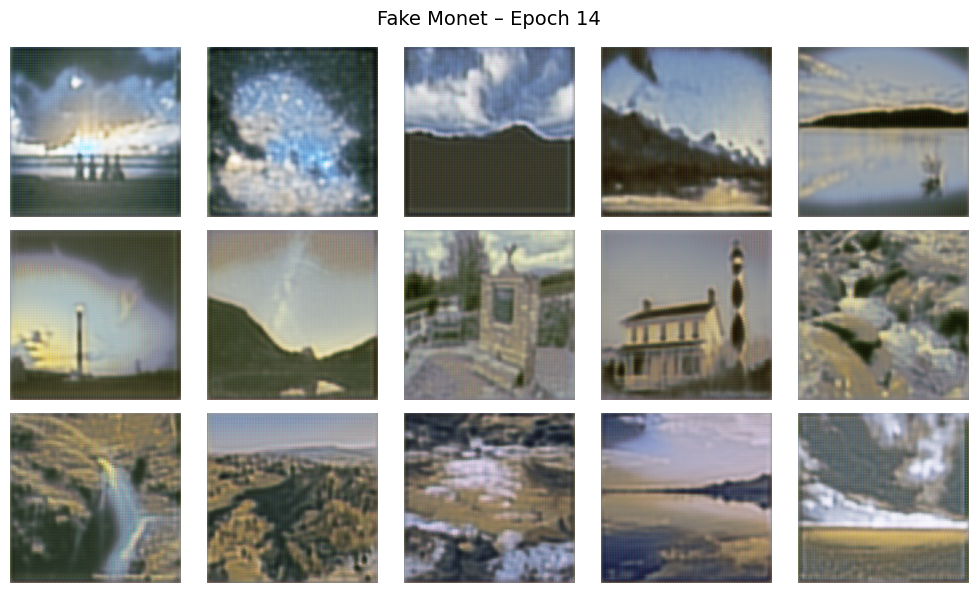

In [4]:
import os
import math
from PIL import Image
import matplotlib.pyplot as plt

def plot_fake_by_epoch(epoch, folder="fake_monet"):
    prefix = f"fake_{epoch}_"

    files = [
        f for f in os.listdir(folder)
        if f.startswith(prefix) and f.lower().endswith(".png")
    ]

    if len(files) == 0:
        print(f"No images found for epoch {epoch}")
        return

    # ordina per step numerico
    files.sort(key=lambda x: int(x.replace(prefix, "").replace(".png", "")))

    n = len(files)
    #cols = int(math.sqrt(n))
    cols = 5
    
    rows = math.ceil(n / cols)
    

    plt.figure(figsize=(cols * 2, rows * 2))

    for i, fname in enumerate(files):
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(f"Fake Monet – Epoch {epoch}", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_fake_by_epoch(epoch=14)


### 3.4 Kaggle Submission
Due to the unavailability of GPU resources in the Kaggle environment, and to the fact that the currently available TPU versions are more recent than those assumed by the official tutorials, it was not possible to follow the provided TPU setup instructions. The referenced tutorials rely on outdated implementations and deprecated workflows that are no longer compatible with the current Kaggle TPU runtime. In particular, the installation procedures based on external setup scripts cannot be replicated, as network access is restricted and the required `curl`-based downloads are no longer functional. As a result, these TPU instructions are effectively non-reproducible in the present environment.

Under these constraints, the only viable and reproducible execution path for this assignment is CPU-based training and generation. In this configuration, generating a single image at a resolution of 256×256 requires approximately 20 seconds. At this rate, producing the required set of more than 7,000 images would take over 2,300 hours of continuous computation, which is clearly impractical within the scope and time limits of the assignment. Consequently, the Kaggle submission associated with this work should be regarded as a participation submission, whose purpose is to demonstrate that the complete pipeline was implemented, executed, and correctly uploaded, rather than to achieve a competitive quantitative score.


## 4. Results

In this chapter, the results of the proposed approach are analyzed primarily from a qualitative perspective. A quantitative, score-driven optimization was not feasible in this setting due to the practical impossibility of iterating efficiently on Kaggle submissions. In particular, the unavailability of GPU resources and the incompatibility and obsolescence of the available TPU setup prevented fast and reproducible experimentation cycles based on leaderboard feedback.

For these reasons, the evaluation focuses on visual inspection and qualitative assessment of the generated images, aiming to verify whether the adopted model is able to capture meaningful structure and stylistic elements under constrained computational conditions. This analysis provides an initial validation of the approach and establishes a baseline for further refinement.

### 4.1 CycleGAN preliminary results

Figure 4.1 shows a grid of Monet-style images generated by the CycleGAN model after 15 epochs, with 15 training steps per epoch, using a reduced image resolution. Despite the limited training budget and the absence of extensive hyperparameter tuning, the generated samples already exhibit several recognizable structural elements. In particular, global scene composition, horizon lines, large shapes, and coarse spatial layouts are preserved, indicating that the model has learned a non-trivial mapping between the photo and Monet domains.

At the same time, the images remain visibly blurry and lack fine-grained texture, brushstroke detail, and color consistency typically associated with high-quality Monet-style generation. These artifacts are expected given the exploratory nature of this experiment, the small number of training iterations, and the constrained computational setting. Overall, these preliminary results suggest that CycleGAN is capable of producing semantically coherent and stylistically aligned outputs even under minimal training conditions, motivating further investigation through targeted hyperparameter tuning in the next section.

![Figure 4.1 – Preliminary CycleGAN results after 15 epochs and 15 steps per epoch. The generated Monet-style images show recognizable global structures and scene layouts, despite limited training and reduced resolution.](./images/41.png)


In [9]:
# CycleGAN single-cell, fully self-contained (dataset loading + training + checkpointing)

import os
import random
import gc
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.utils import save_image

# -----------------------
# Paths (ONLY THINGS TO ADAPT IF NEEDED)
# -----------------------
MONET_DIR = "data/monet_jpg"
PHOTO_DIR = "data/photo_jpg"
CHECKPOINT_PATH = "cyclegan_ckpt.pt"
FAKE_DIR = "fake_monet_v2"
os.makedirs(FAKE_DIR, exist_ok=True)

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Controls
# -----------------------
EPOCHS = 30
MAX_STEPS_PER_EPOCH = 40
BATCH_SIZE = 1

IMAGE_SIZE = 256
CHANNELS_IMG = 3
LAMBDA = 10.0


# -----------------------
# Transforms
# -----------------------
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*CHANNELS_IMG, [0.5]*CHANNELS_IMG),
])

# -----------------------
# Utility: load image paths
# -----------------------
def load_image_paths(folder):
    return [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

monet_images = load_image_paths(MONET_DIR)
photo_images = load_image_paths(PHOTO_DIR)

print(f"Loaded {len(monet_images)} Monet images")
print(f"Loaded {len(photo_images)} Photo images")

# -----------------------
# Dataset
# -----------------------
class CycleGANDataset(Dataset):
    def __init__(self, monet_paths, photo_paths, transform):
        self.monet = monet_paths
        self.photo = photo_paths
        self.transform = transform

    def __len__(self):
        return max(len(self.monet), len(self.photo))

    def __getitem__(self, idx):
        monet_path = self.monet[idx % len(self.monet)]
        photo_path = random.choice(self.photo)

        monet = Image.open(monet_path).convert("RGB")
        photo = Image.open(photo_path).convert("RGB")

        if self.transform:
            monet = self.transform(monet)
            photo = self.transform(photo)

        return monet, photo

dataset = CycleGANDataset(monet_images, photo_images, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# -----------------------
# Models
# -----------------------
class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c, c, 3, padding=1),
            nn.InstanceNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, c, 3, padding=1),
            nn.InstanceNorm2d(c),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            *[ResidualBlock(256) for _ in range(9)],

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1),
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
F = Generator().to(device)
DX = Discriminator().to(device)
DY = Discriminator().to(device)

# -----------------------
# Losses & Optimizers
# -----------------------
adv_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

opt_G = optim.Adam(list(G.parameters()) + list(F.parameters()), lr=2e-4, betas=(0.5, 0.999))
opt_DX = optim.Adam(DX.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_DY = optim.Adam(DY.parameters(), lr=2e-4, betas=(0.5, 0.999))
# -----------------------
# Checkpoint helpers
# -----------------------
def save_ckpt(epoch, step):
    torch.save({
        "epoch": epoch,
        "step": step,
        "G": G.state_dict(),
        "F": F.state_dict(),
        "DX": DX.state_dict(),
        "DY": DY.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_DX": opt_DX.state_dict(),
        "opt_DY": opt_DY.state_dict(),
    }, CHECKPOINT_PATH)

# -----------------------
# Training (bounded, disk-first)
# -----------------------
for epoch in range(EPOCHS):
    for step, (monet, photo) in enumerate(loader):

        if step >= MAX_STEPS_PER_EPOCH:
            save_ckpt(epoch, step)
            print(f"Stopped at epoch {epoch}, step {step}")
            break

        monet = monet.to(device)
        photo = photo.to(device)

        fake_monet = G(photo)
        fake_photo = F(monet)

        # save fake monet immediately to disk
        with torch.no_grad():
            img = (fake_monet.detach().cpu() * 0.5 + 0.5).clamp(0, 1)
            save_image(img, f"{FAKE_DIR}/fake_{epoch}_{step}.png")

        rec_photo = F(fake_monet)
        rec_monet = G(fake_photo)

        id_photo = F(photo)
        id_monet = G(monet)

        loss_G = adv_loss(DY(fake_monet), torch.ones_like(DY(fake_monet)))
        loss_F = adv_loss(DX(fake_photo), torch.ones_like(DX(fake_photo)))
        loss_cycle = cycle_loss(rec_photo, photo) + cycle_loss(rec_monet, monet)
        loss_id = identity_loss(id_photo, photo) + identity_loss(id_monet, monet)

        loss_gen = loss_G + loss_F + LAMBDA * loss_cycle + 0.5 * LAMBDA * loss_id

        opt_G.zero_grad()
        loss_gen.backward()
        opt_G.step()

        loss_DX = (
            adv_loss(DX(photo), torch.ones_like(DX(photo))) +
            adv_loss(DX(fake_photo.detach()), torch.zeros_like(DX(fake_photo)))
        ) * 0.5
        opt_DX.zero_grad()
        loss_DX.backward()
        opt_DX.step()

        loss_DY = (
            adv_loss(DY(monet), torch.ones_like(DY(monet))) +
            adv_loss(DY(fake_monet.detach()), torch.zeros_like(DY(fake_monet)))
        ) * 0.5
        opt_DY.zero_grad()
        loss_DY.backward()
        opt_DY.step()

# -----------------------
# Cleanup (important for VRAM)
# -----------------------
del fake_monet, fake_photo, rec_photo, rec_monet, monet, photo
gc.collect()
torch.cuda.empty_cache()


Loaded 300 Monet images
Loaded 7038 Photo images
Stopped at epoch 0, step 40
Stopped at epoch 1, step 40
Stopped at epoch 2, step 40
Stopped at epoch 3, step 40
Stopped at epoch 4, step 40
Stopped at epoch 5, step 40
Stopped at epoch 6, step 40
Stopped at epoch 7, step 40
Stopped at epoch 8, step 40
Stopped at epoch 9, step 40
Stopped at epoch 10, step 40
Stopped at epoch 11, step 40
Stopped at epoch 12, step 40
Stopped at epoch 13, step 40
Stopped at epoch 14, step 40
Stopped at epoch 15, step 40
Stopped at epoch 16, step 40
Stopped at epoch 17, step 40
Stopped at epoch 18, step 40
Stopped at epoch 19, step 40
Stopped at epoch 20, step 40
Stopped at epoch 21, step 40
Stopped at epoch 22, step 40
Stopped at epoch 23, step 40
Stopped at epoch 24, step 40
Stopped at epoch 25, step 40
Stopped at epoch 26, step 40
Stopped at epoch 27, step 40
Stopped at epoch 28, step 40
Stopped at epoch 29, step 40


### 4.2 Hyperparameter tuning

Figure 4.2, shown below, reports a qualitative snapshot of the model behavior after a more extended training phase.
This time, these are the hyperparameters used:
- image size: 256x256
- steps per epoch: 40
- number of epochs: 30

The figure shows 20 samples generated during the last epoch, allowing a direct comparison with the preliminary results discussed in Section 4.1.

Compared to the earlier configuration, the generated images exhibit a clearer separation between foreground and background elements and a more coherent global composition. Landscape structures such as horizons, water surfaces, vegetation, architectural elements, and sky regions are more consistently formed, indicating that the CycleGAN has started to better capture higher-level spatial relationships rather than relying solely on local texture transfer. Color distributions also appear more stable, with smoother transitions and fewer abrupt artifacts, suggesting improved convergence of the adversarial and cycle-consistency objectives.

At the same time, some limitations remain evident. Certain samples still present distortions, repetitive patterns, or local instabilities, particularly in regions with fine geometric details. These artifacts highlight the sensitivity of CycleGAN training to hyperparameter choices and the limited number of iterations feasible under the computational constraints of the Kaggle environment.

Overall, these results confirm that increasing the number of epochs and steps per epoch leads to a noticeable qualitative improvement over the baseline configuration, validating the effectiveness of the selected hyperparameter adjustments. A more systematic tuning strategy and longer training schedules would likely further enhance visual fidelity, but were constrained by hardware availability and execution time in this assignment context.

![Figure 4.2: CycleGAN hyperparameter tuning results at higher training budget. The figure shows 20 generated Monet-style images sampled from epoch 30, after 40 training steps per epoch. Compared to preliminary results, the generated images exhibit more coherent global structures, improved color consistency, and more recognizable scene layouts, indicating that extended training and basic hyperparameter adjustments positively impact visual quality.](./images/42.png)

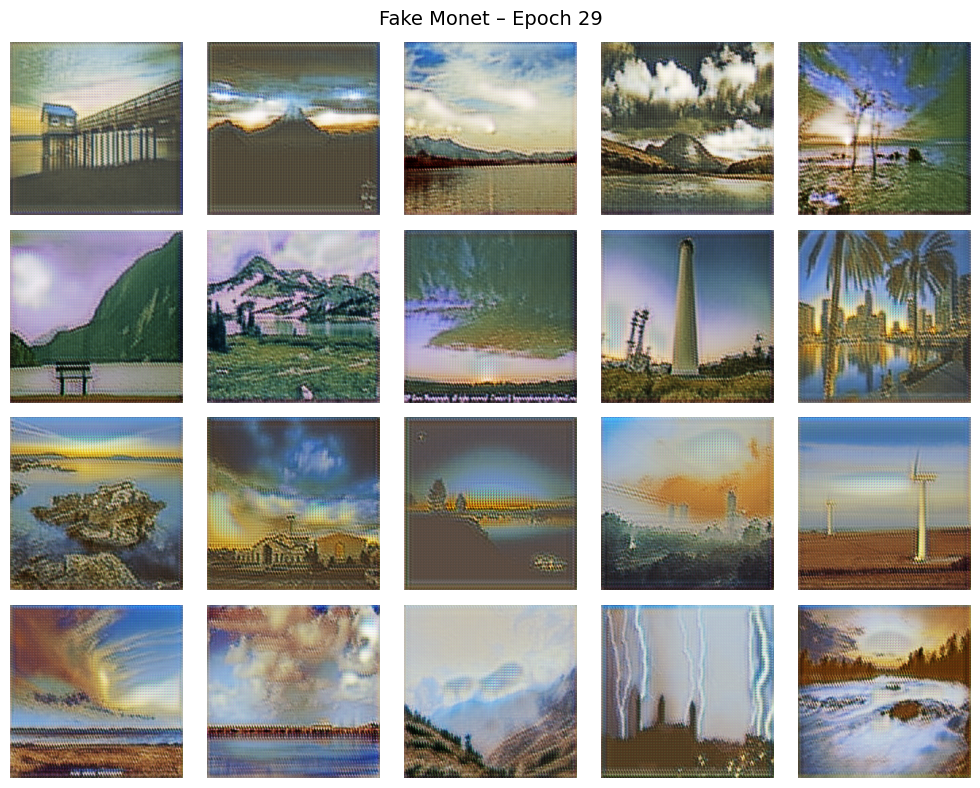

In [11]:

plot_fake_by_epoch(epoch=29,folder="fake_monet_v2_2")

### 4.2.2 Note on image dimension

Increasing the image resolution leads to an approximately linear improvement in perceptual quality, as higher spatial dimensions allow the model to represent finer structures, smoother gradients, and more detailed textures. In preliminary tests, larger image sizes resulted in more coherent global layouts and reduced local artifacts, confirming this expected behavior.

However, the computational cost associated with higher resolutions grows quadratically with image size. Both memory consumption and training time increase significantly, making extended experimentation at higher resolutions impractical within the available computational constraints. In particular, while experiments at a resolution of 512×512 produced visually promising results, the required training time and resource usage were not compatible with the execution limits of the Kaggle environment.

Additionally, the competition explicitly requires generated images to be submitted at a resolution of 256×256. For these reasons, higher-resolution variants were not further explored, and the experiments were constrained to the target resolution mandated by the competition.


### 4.3 Real vs CycleGAN Monet Comparison – Results

The qualitative comparison between real photographs and their CycleGAN-generated Monet-style counterparts highlights the model’s ability to perform a coherent cross-domain translation. Across the examined samples, the generated images preserve the global semantic structure of the input scenes, including horizon placement, dominant shapes, and spatial composition, while consistently applying stylistic features characteristic of Monet’s paintings. These features include a warmer and compressed color palette, softened contours, reduced high-frequency details, and the emergence of brushstroke-like textures.

Importantly, the transformation is content-aware: different photographic scenes yield distinct stylizations rather than a uniform texture overlay, indicating that the generator has learned a meaningful mapping between the two domains rather than a trivial filtering operation. While minor artifacts and texture repetitions are observable, particularly in homogeneous regions such as skies or water surfaces, they do not obscure the overall scene structure.

Overall, the comparison demonstrates that, even under limited training iterations and constrained computational resources, the CycleGAN successfully captures the essential characteristics of the Monet style while maintaining recognizability of the original photographic content.

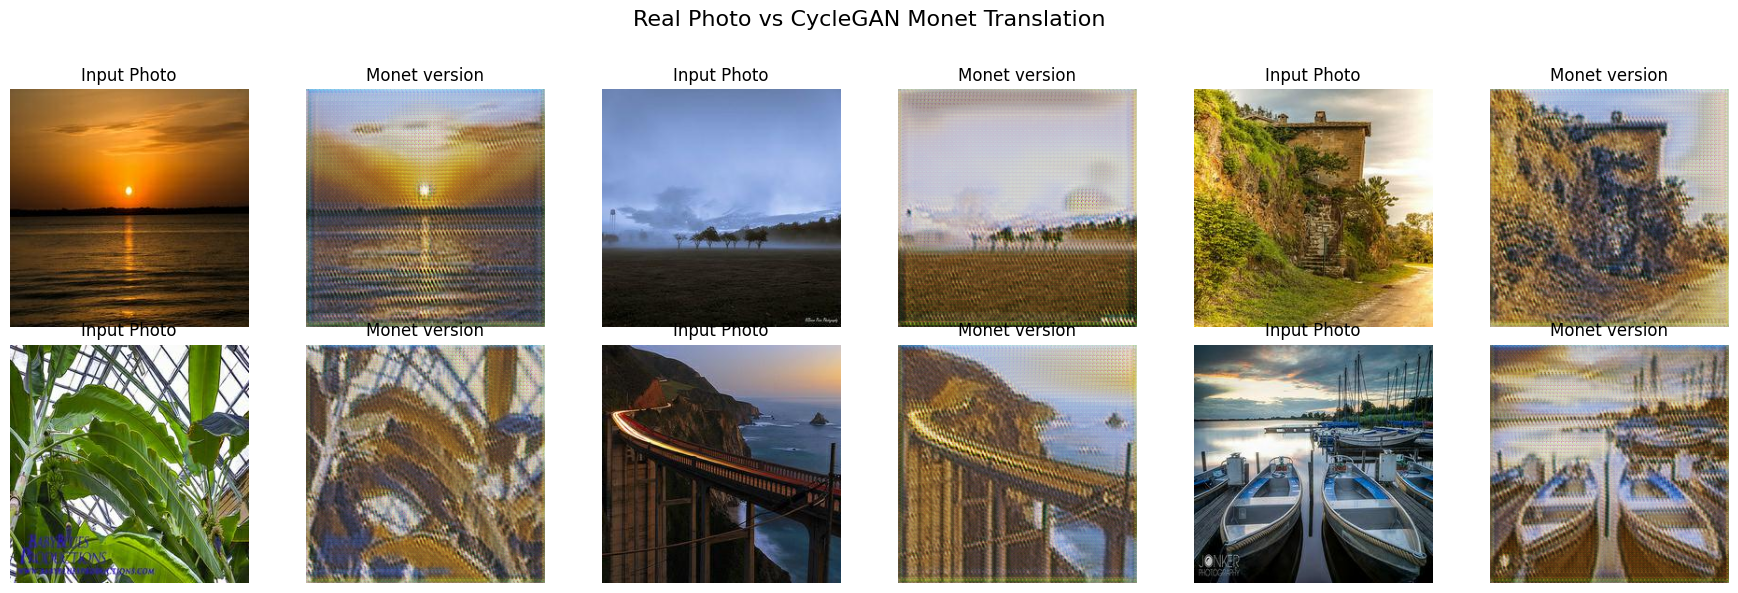

In [37]:
import matplotlib.pyplot as plt

NUM_PAIRS = 6          # 6 coppie → 12 immagini
ROWS = 2               # 3 coppie per riga
COLS = 6               # (Photo, Monet) x 3
PAD = 0.4              # spazio tra coppie

G.eval()

fig, axes = plt.subplots(
    nrows=ROWS,
    ncols=COLS,
    figsize=(COLS * 3, ROWS * 3)
)

pair_idx = 0

with torch.no_grad():
    for monet, photo in loader:
        photo = photo.to(device)

        fake_monet = G(photo)

        for b in range(photo.size(0)):
            if pair_idx >= NUM_PAIRS:
                break

            row = pair_idx // 3
            col = (pair_idx % 3) * 2

            # Input Photo
            axes[row, col].imshow(
                denorm(photo[b]).permute(1, 2, 0).cpu()
            )
            axes[row, col].set_title("Input Photo")
            axes[row, col].axis("off")

            # Fake Monet
            axes[row, col + 1].imshow(
                denorm(fake_monet[b]).permute(1, 2, 0).cpu()
            )
            axes[row, col + 1].set_title("Monet version")
            axes[row, col + 1].axis("off")

            pair_idx += 1

        if pair_idx >= NUM_PAIRS:
            break

plt.suptitle("Real Photo vs CycleGAN Monet Translation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=PAD, w_pad=PAD)
plt.show()


### 4.4 GAN comparison

Figure 4.3 provides a qualitative comparison between DCGAN, WGAN-GP, and CycleGAN on the Monet-style image generation task.

DCGAN produces outputs dominated by high-frequency noise and repetitive texture patterns, with no recognizable global structure. While some color distributions vaguely resemble the target domain, the model fails to capture semantic content or coherent scene layouts, making it unsuitable for style translation in this context.

WGAN-GP shows a modest improvement in stability and color smoothness compared to DCGAN, but the generated images remain largely amorphous. Some localized structures begin to emerge, yet global composition is still absent and results remain visually ambiguous.

CycleGAN, by contrast, generates images with clearly recognizable elements such as landscapes, horizons, architectural shapes, and consistent color palettes. The preservation of spatial structure from the input photos, combined with Monet-like stylistic transformations, results in outputs that are qualitatively superior and aligned with the objectives of the task.

Overall, this comparison highlights that unpaired image-to-image translation with CycleGAN is fundamentally better suited for this problem than unconditional GAN variants such as DCGAN and WGAN-GP.


![Figure 4.2: CycleGAN hyperparameter tuning results at higher training budget. The figure shows 20 generated Monet-style images sampled from epoch 30, after 40 training steps per epoch. Compared to preliminary results, the generated images exhibit more coherent global structures, improved color consistency, and more recognizable scene layouts, indicating that extended training and basic hyperparameter adjustments positively impact visual quality.](./images/GAN-comparison.jpg)


### 4.5 Real Monet vs CycleGAN color information comparison

Below is a comparison of the RGB channel distributions and saturation (HSV) for two images: an original Monet painting and an image generated by the CycleGAN model. Although the depicted subjects are different and therefore contain different amounts and distributions of information across the color channels, several relevant structural similarities can still be observed.

In particular, the distributions of the R, G, and B channels exhibit globally comparable behaviors in terms of dynamic range and overall shape. While the peaks do not perfectly align, the presence of similar multimodal structures and a coherent balance among the channels suggests that the model has learned characteristic chromatic relationships of Monet’s style, rather than applying a simple uniform color shift or a static chromatic bias.

Additional insight is provided by the analysis of saturation in the HSV color space. The saturation distribution of the generated image is concentrated mainly in the low-to-mid range, with a gradual tail toward higher saturation values, closely mirroring the behavior observed in the original painting. This pattern is consistent with the impressionist rendering style, which favors diffuse color harmonies and gradual variations over highly saturated and strongly contrasted colors.

This comparison therefore indicates that the CycleGAN model does not merely reproduce superficial visual features, but also approximates higher-level chromatic statistics characteristic of Monet’s style. These observations complement the qualitative analysis presented earlier and provide quantitative support for the model’s ability to learn and transfer stylistic color information, even under computational constraints and with a limited number of training epochs and steps.


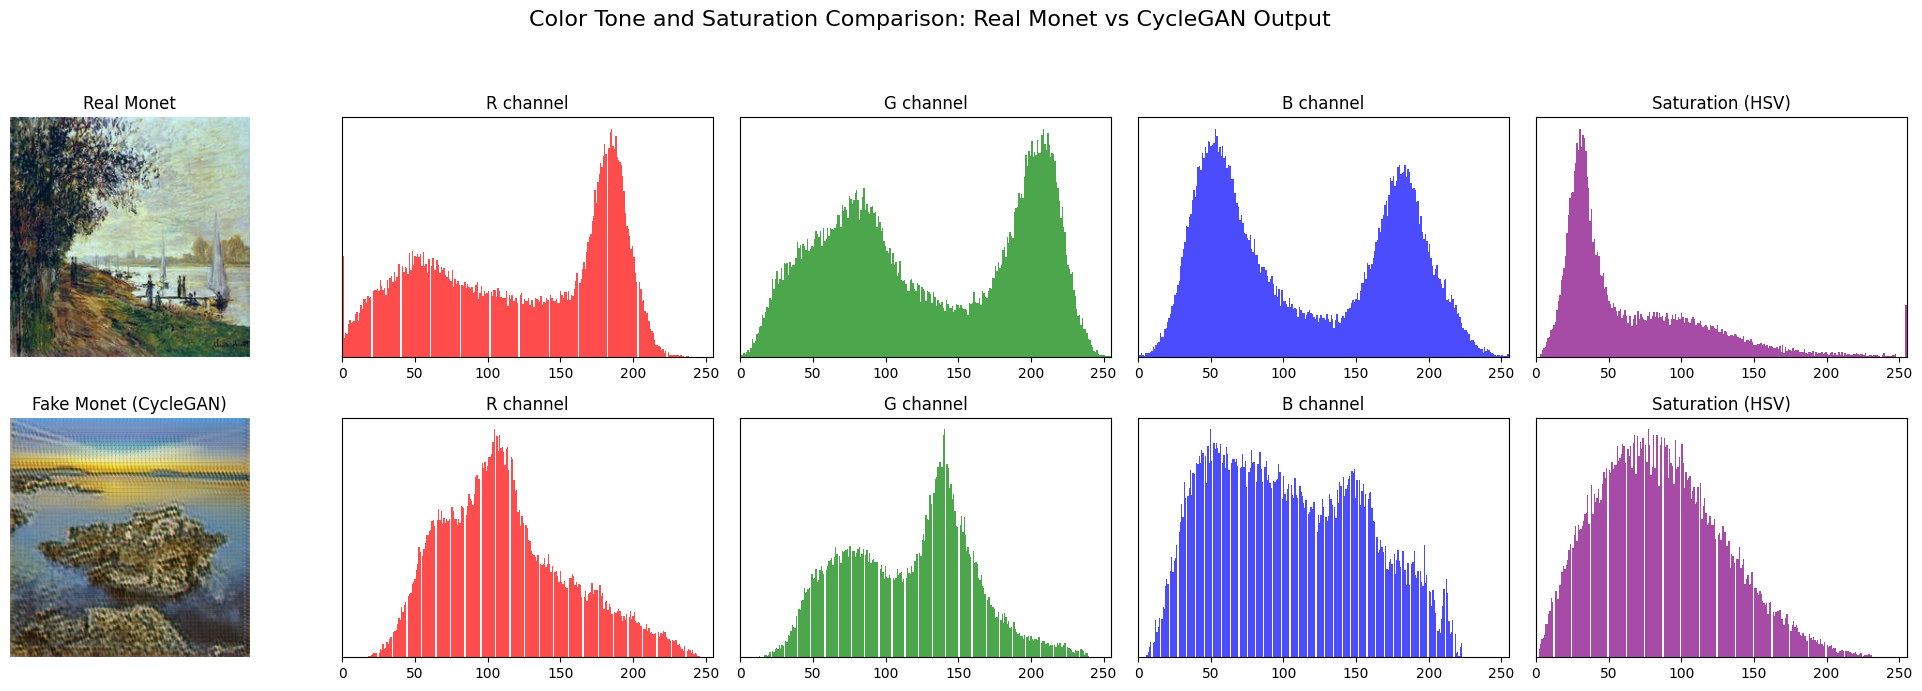

In [43]:
# Color and saturation histogram comparison: Real Monet vs Fake Monet

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------- paths (edit if needed) --------
REAL_MONET_PATH = "data/monet_jpg/1078363ff0.jpg"
FAKE_MONET_PATH = "fake_monet_v2_2/fake_29_26.png"

# -------- load images (RGB) --------
real = cv2.cvtColor(cv2.imread(REAL_MONET_PATH), cv2.COLOR_BGR2RGB)
fake = cv2.cvtColor(cv2.imread(FAKE_MONET_PATH), cv2.COLOR_BGR2RGB)

# -------- convert to HSV for saturation --------
real_hsv = cv2.cvtColor(real, cv2.COLOR_RGB2HSV)
fake_hsv = cv2.cvtColor(fake, cv2.COLOR_RGB2HSV)

real_sat = real_hsv[:, :, 1]
fake_sat = fake_hsv[:, :, 1]

# -------- plotting layout --------
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

colors = ["red", "green", "blue"]
labels = ["R", "G", "B"]

# -------- row 1: Real Monet --------
axes[0, 0].imshow(real)
axes[0, 0].set_title("Real Monet")
axes[0, 0].axis("off")

for i, (c, lbl) in enumerate(zip(colors, labels)):
    axes[0, i + 1].hist(real[:, :, i].ravel(), bins=256, color=c, alpha=0.7)
    axes[0, i + 1].set_title(f"{lbl} channel")
    axes[0, i + 1].set_xlim(0, 255)
    axes[0, i + 1].set_yticks([])

axes[0, 4].hist(real_sat.ravel(), bins=256, color="purple", alpha=0.7)
axes[0, 4].set_title("Saturation (HSV)")
axes[0, 4].set_xlim(0, 255)
axes[0, 4].set_yticks([])

# -------- row 2: Fake Monet --------
axes[1, 0].imshow(fake)
axes[1, 0].set_title("Fake Monet (CycleGAN)")
axes[1, 0].axis("off")

for i, (c, lbl) in enumerate(zip(colors, labels)):
    axes[1, i + 1].hist(fake[:, :, i].ravel(), bins=256, color=c, alpha=0.7)
    axes[1, i + 1].set_title(f"{lbl} channel")
    axes[1, i + 1].set_xlim(0, 255)
    axes[1, i + 1].set_yticks([])

axes[1, 4].hist(fake_sat.ravel(), bins=256, color="purple", alpha=0.7)
axes[1, 4].set_title("Saturation (HSV)")
axes[1, 4].set_xlim(0, 255)
axes[1, 4].set_yticks([])

plt.suptitle(
    "Color Tone and Saturation Comparison: Real Monet vs CycleGAN Output",
    fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



## 5. Conclusion

### 5.1 Overview

This project investigated generative approaches for Monet-style image synthesis, initially starting from simpler and well-known GAN architectures such as DCGAN and WGAN-GP. These models were implemented from scratch with the expectation that, given sufficient training, they could capture basic stylistic features of the target domain.

However, empirical results showed that vanilla implementations of DCGAN and WGAN-GP are not well suited for this specific task and competition setting. In the absence of paired data and explicit structural constraints, these architectures struggled to produce visually coherent outputs, often failing to preserve semantic content while attempting stylistic adaptation. This limitation became evident early in the experimentation phase.

As a result, the focus shifted toward CycleGAN, whose design explicitly addresses unpaired image-to-image translation through cycle-consistency. Under the same computational constraints, CycleGAN demonstrated a markedly superior ability to transfer stylistic properties while maintaining recognizable scene structure. The remainder of the work therefore concentrated on analyzing CycleGAN results, validating its effectiveness through qualitative comparisons, and producing a complete, reproducible submission pipeline within the limits imposed by the Kaggle environment.


### 5.2 What worked and what did not

#### What worked: CycleGAN

The CycleGAN architecture proved to be well suited for the unpaired style transfer task required by the competition. Its cycle-consistency constraint enabled the model to preserve the semantic structure of the input photographs while learning stylistic characteristics of Monet’s paintings. Even with limited training iterations and reduced image resolution, the generated outputs showed coherent scene layouts, recognizable content, and consistent stylistic cues.
Qualitative inspection across epochs and steps confirmed a gradual improvement in visual coherence, and color distribution analyses further supported the model’s ability to approximate Monet-like chromatic statistics. Overall, CycleGAN delivered stable and interpretable results under constrained computational conditions.

#### What did not work: DCGAN and WGAN-GP

Vanilla implementations of DCGAN and WGAN-GP were not effective for this task. Despite correct from-scratch implementations, these models struggled to maintain semantic structure and failed to produce meaningful stylistic transformations in an unpaired setting. Their outputs were either visually unstable or overly focused on local textures, making them unsuitable for the competition objectives.
Additionally, practical limitations related to the execution environment significantly restricted experimentation. The lack of accessible GPU resources and the inability to rely on current TPU workflows—due to outdated and non-functional documentation—prevented extended training, large-scale hyperparameter tuning, and high-resolution experiments.

### 5.3 Takeaways

A key takeaway from this work is that architectural suitability is more important than model complexity when addressing a specific task. While DCGAN and WGAN-GP are powerful generative models, they are not inherently designed for unpaired image-to-image translation and therefore perform poorly in this context without substantial modifications.

Another important insight is the value of qualitative and distribution-based analysis when quantitative metrics are difficult to obtain or unreliable under constrained settings. Visual comparisons, progression across epochs, and color distribution analyses provided robust evidence of learning progress and stylistic alignment.

Finally, this assignment emphasized the gap that can exist between theoretical tutorials and practical execution environments. Reproducibility is strongly influenced by infrastructure maturity, and model evaluation strategies must often adapt to these external constraints.

### 5.4 Kaggle submission score

Here we report the screenshot of the Kaggle submission associated with this work. 

It is important to emphasize that the obtained score does not reflect the qualitative results discussed in the previous sections. Due to the unavailability of GPU resources and the impracticality of using accelerated TPU kernels, it was not possible to participate under conditions comparable to those assumed by the competition setup. In particular, the requirement to generate more than 7,000 images using CPU-only execution makes a full-scale and iterative submission process computationally infeasible.

As a consequence, the reported Kaggle score should be interpreted solely as a participation and pipeline-validation score. It demonstrates that the notebook correctly implemented the end-to-end procedure required by the competition, including image generation, packaging, and submission of a valid ZIP archive containing more than 7,000 images in the expected format.

This outcome is fully aligned with the stated objectives of the Week 5 assignment, where the primary focus was not on leaderboard performance, but on the correct implementation, description, and understanding of the complete generative workflow.

![Figure 5.1: Kaggle submission scoreCycleGAN hyperparameter tuning results at higher training budget. The figure shows 20 generated Monet-style images sampled from epoch 30, after 40 training steps per epoch. Compared to preliminary results, the generated images exhibit more coherent global structures, improved color consistency, and more recognizable scene layouts, indicating that extended training and basic hyperparameter adjustments positively impact visual quality.](images/mg-monet-kaggle-score.png)



### 5.5 Future work

Future extensions of this work would primarily focus on scaling and refinement. With access to stable GPU or modern TPU environments, longer training schedules and higher-resolution images could be explored to improve texture coherence and fine-grained details. Additionally, experimenting with image resolutions beyond 256×256, while computationally more expensive, could further enhance visual fidelity.

From an evaluation perspective, incorporating perceptual metrics such as FID or LPIPS, once computationally feasible, would allow for a more objective comparison across models and configurations.

Finally, extending the analysis to multiple artistic styles or multi-domain translation could provide further insight into the generalization capabilities of unpaired image-to-image translation models.